In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

In [ ]:
# Import dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Combinar datasets
all_data = pd.concat([train.drop('Survived', axis=1), test], sort=False).reset_index(drop=True)
all_labels = train['Survived']

In [4]:
# Preencher valores ausentes nas colunas numéricas 'Age' e 'Fare' com suas medianas
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].median())
# Preencher valores ausentes na coluna categórica 'Embarked' com o valor mais comum ('S')
all_data['Embarked'] = all_data['Embarked'].fillna('S')

1. Engenharia de Features

In [5]:
# Extrair o título de cada nome (e.g., Mr., Mrs., Miss.)
all_data['Title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
# Mapear títulos raros para uma categoria 'Rare' e alguns para títulos mais comuns
all_data['Title'] = all_data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Mlle', 'Ms', 'Mme'],
                                               ['Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Miss', 'Miss', 'Mrs'])
# Verificar a distribuição dos novos títulos
print("Distribuição de Títulos após agrupamento:")
print(all_data['Title'].value_counts())

Distribuição de Títulos após agrupamento:
Title
Mr              757
Miss            264
Mrs             198
Master           61
Rare             28
the Countess      1
Name: count, dtype: int64


In [6]:
# Tamanho da família
# Criar uma feature 'FamilySize' combinando 'SibSp' (irmãos/cônjuges) e 'Parch' (pais/filhos)
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1 # +1 para incluir o próprio passageiro
# Criar categorias de tamanho de família
all_data['IsAlone'] = (all_data['FamilySize'] == 1).astype(int) # 1 se estiver sozinho, 0 caso contrário
print("Distribuição de IsAlone:")
print(all_data['IsAlone'].value_counts())

Distribuição de IsAlone:
IsAlone
1    790
0    519
Name: count, dtype: int64


In [7]:
# Extrair informações da cabine
# Preencher valores ausentes na 'Cabin' com 'Unknown' ANTES de extrair o deck
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
# Extrair a letra da cabine (primeira letra indica o deck)
all_data['Deck'] = all_data['Cabin'].apply(lambda x: x[0])
# Agrupar decks raros ou sem sentido
all_data['Deck'] = all_data['Deck'].replace(['T'], 'Unknown')
print("Distribuição de Deck:")
print(all_data['Deck'].value_counts())

Distribuição de Deck:
Deck
U          1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
Unknown       1
Name: count, dtype: int64


In [8]:
# Descartar features que não serão usadas ou já foram transformadas
# 'PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch' não são mais necessárias
all_data_processed = all_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1)

2. Codifição de Features Categóricas

In [9]:
# Identificar colunas categóricas e numéricas para pré-processamento
categorical_features = ['Sex', 'Embarked', 'Pclass', 'Title', 'Deck'] # Pclass é numérica, mas tratada como categórica aqui
numerical_features = ['Age', 'Fare', 'FamilySize', 'IsAlone']

# Criar um ColumnTransformer para aplicar diferentes transformações a diferentes colunas
# OneHotEncoder para colunas categóricas (handle_unknown='ignore' evita erros para categorias não vistas)
# StandardScaler para colunas numéricas (padroniza para média 0 e desvio padrão 1)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

3. Divisáo dos Dados (Treino e Teste)

In [10]:
# Separar os dados de volta em treino e teste (baseado no 'Survived' do dataset original)
# 'X' são as features para o treinamento e validação do modelo
X = all_data_processed.iloc[:len(train)]
# 'y' são os rótulos (Survived) correspondentes
y = all_labels

# Dividir o conjunto de treino em treino e validação para avaliação do modelo
# test_size=0.2 significa 20% para validação, random_state para reprodutibilidade
# stratify=y garante que a proporção de classes em y_train e y_val seja a mesma que em y
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 'X_test_final' são as features para as previsões finais a serem submetidas
X_test_final = all_data_processed.iloc[len(train):]

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de validação: {X_val.shape[0]} amostras")
print(f"Tamanho do conjunto de teste final: {X_test_final.shape[0]} amostras")
print("\n")

Tamanho do conjunto de treino: 712 amostras
Tamanho do conjunto de validação: 179 amostras
Tamanho do conjunto de teste final: 418 amostras




4. Treinamento do Modelo Adaboost

In [11]:
# --- 4. Treinamento do Modelo AdaBoost ---

# Criar um pipeline que primeiro pré-processa os dados e depois aplica o classificador
# O 'preprocessor' aplica StandardScaler e OneHotEncoder
# O 'classifier' é um AdaBoostClassifier com um DecisionTreeClassifier como estimador base
ada_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', AdaBoostClassifier(
                                   estimator=DecisionTreeClassifier(max_depth=1, random_state=42), # Estimador base (árvore rasa)
                                   n_estimators=100, # Número de estimadores (árvores)
                                   learning_rate=1.0, # Taxa de aprendizado
                                   random_state=42
                               ))])

# Treinar o modelo usando o conjunto de treino pré-processado
ada_pipeline.fit(X_train, y_train)
print("Treinamento concluído!\n")

Treinamento concluído!



5. Avalia;áo do Modelo

In [12]:
# Fazer previsões no conjunto de validação para verificar o desempenho
y_pred_val = ada_pipeline.predict(X_val)

# Avaliar a acurácia do modelo
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Acurácia no conjunto de validação: {accuracy:.4f}\n")

# Relatório de classificação detalhado (precisão, recall, f1-score por classe)
print("Relatório de Classificação no conjunto de validação:")
print(classification_report(y_val, y_pred_val))

# Matriz de Confusão para visualizar erros e acertos do classificador
print("Matriz de Confusão no conjunto de validação:")
print(confusion_matrix(y_val, y_pred_val))

# Validação Cruzada (Cross-Validation) para uma avaliação mais robusta e menos dependente de uma única divisão
print("\nRealizando Validação Cruzada (5-fold)...")
cv_scores = cross_val_score(ada_pipeline, X, y, cv=5, scoring='accuracy')
print(f"Acurácias da Validação Cruzada: {cv_scores}")
print(f"Acurácia Média da Validação Cruzada: {cv_scores.mean():.4f}")
print(f"Desvio Padrão da Validação Cruzada: {cv_scores.std():.4f}\n")

Acurácia no conjunto de validação: 0.8045

Relatório de Classificação no conjunto de validação:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       110
           1       0.73      0.78      0.76        69

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.80       179
weighted avg       0.81      0.80      0.81       179

Matriz de Confusão no conjunto de validação:
[[90 20]
 [15 54]]

Realizando Validação Cruzada (5-fold)...
Acurácias da Validação Cruzada: [0.81005587 0.79213483 0.79775281 0.82022472 0.8258427 ]
Acurácia Média da Validação Cruzada: 0.8092
Desvio Padrão da Validação Cruzada: 0.0128



6. Previsáo e Geração do Arquivo de Submission

In [13]:
# Fazer previsões no conjunto de teste final (X_test_final)
print("Gerando previsões para o arquivo de submissão...")
# Se você usou GridSearchCV, use 'best_ada_model' aqui; caso contrário, use 'ada_pipeline'
final_predictions = ada_pipeline.predict(X_test_final).astype(int)

# Criar o DataFrame de submissão no formato exigido
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': final_predictions})

# Salvar o arquivo de submissão em formato CSV, sem o índice do DataFrame
submission_filename = 'submission_adaboost.csv'
submission.to_csv(submission_filename, index=False)

print(f"Arquivo de submissão '{submission_filename}' criado com sucesso!")
print("\n5 primeiras linhas do arquivo de submissão:")
print(submission.head())


Gerando previsões para o arquivo de submissão...
Arquivo de submissão 'submission_adaboost.csv' criado com sucesso!

5 primeiras linhas do arquivo de submissão:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


7. Visualizações Adicionais


--- Gerando Visualizações Adicionais ---


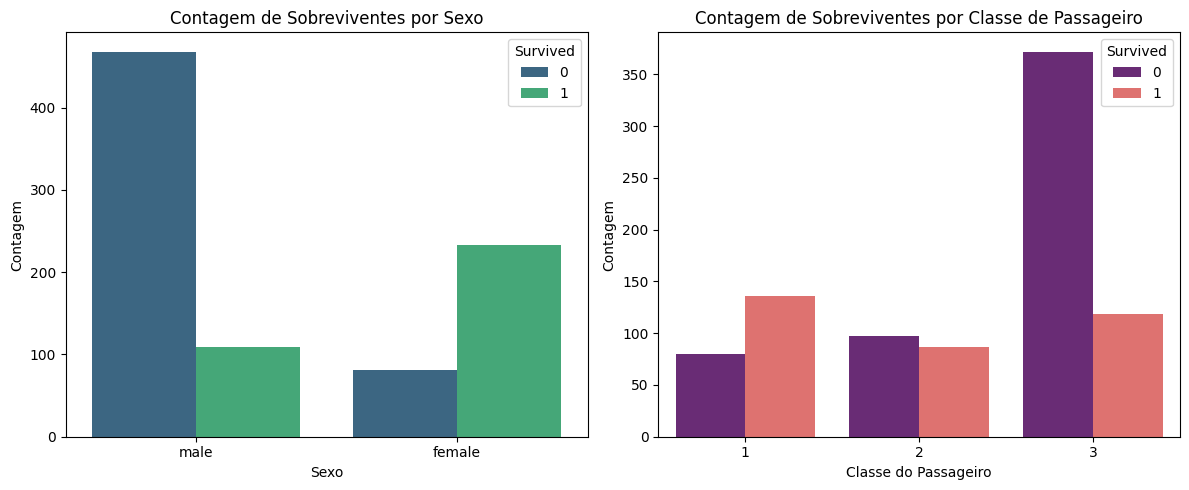

[Image of Contagem de Sobreviventes por Sexo e Classe do Passageiro]


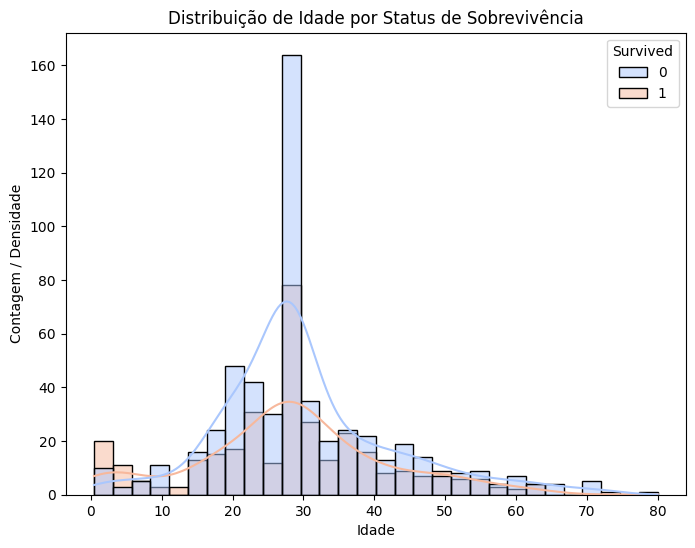

[Image of Distribuição de Idade por Status de Sobrevivência]


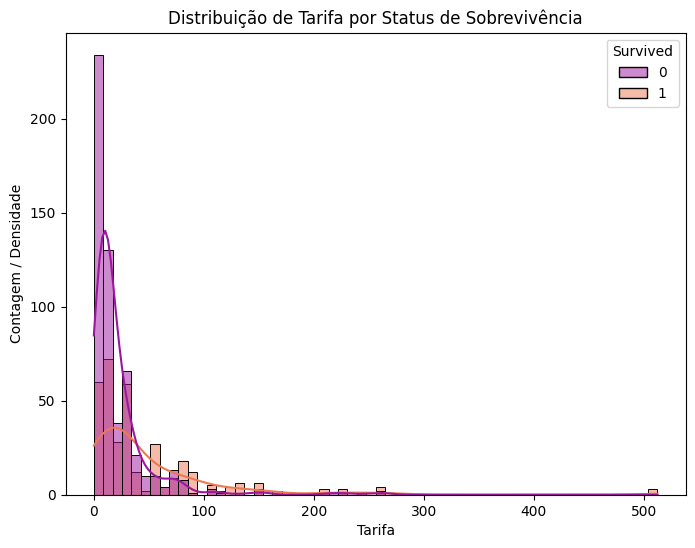

[Image of Distribuição de Tarifa por Status de Sobrevivência]


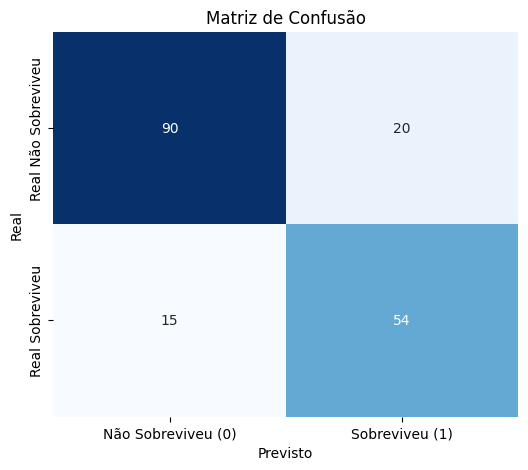

[Image of Matriz de Confusão]


<Figure size 700x600 with 0 Axes>

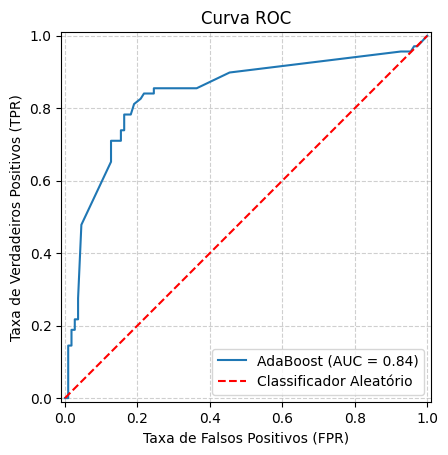

[Image of Curva ROC e AUC]

Calculando e plotando Importância das Features...


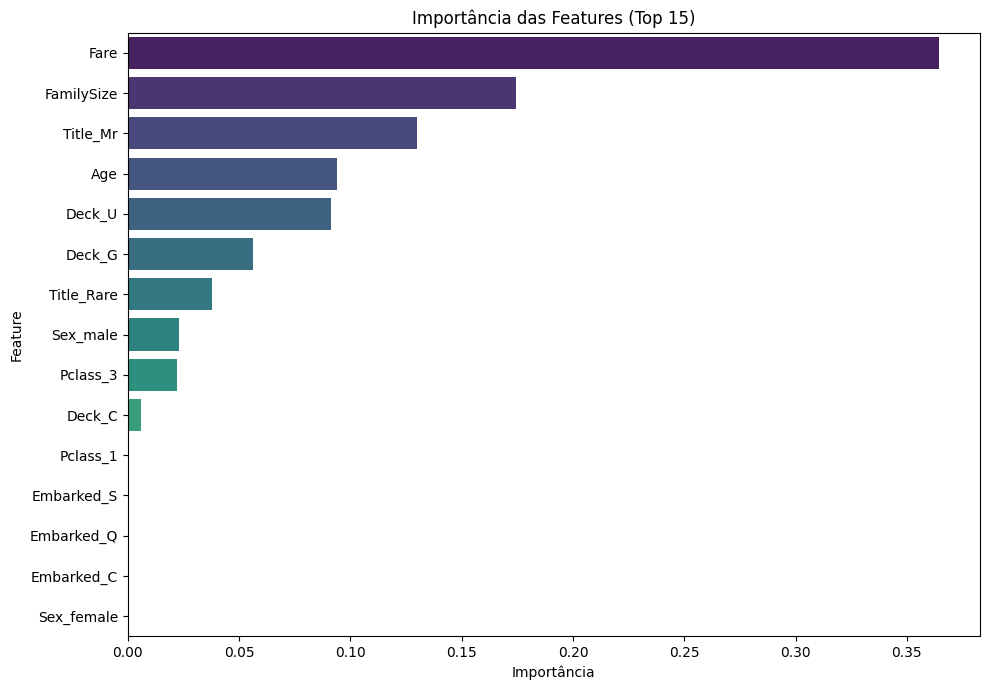

[Image of Importância das Features]


In [14]:
print("\n--- Gerando Visualizações Adicionais ---")

# Criar um DataFrame temporário para visualizações que combinam features e rótulos
# Incluir a coluna 'Survived' para gráficos de relação com a sobrevivência
temp_df_vis = pd.concat([all_data_processed.iloc[:len(train)].copy(), all_labels], axis=1)

# Visualização 7.1: Sobrevivência por Sexo e Pclass
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=temp_df_vis, x='Sex', hue='Survived', palette='viridis')
plt.title('Contagem de Sobreviventes por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Contagem')

plt.subplot(1, 2, 2)
sns.countplot(data=temp_df_vis, x='Pclass', hue='Survived', palette='magma')
plt.title('Contagem de Sobreviventes por Classe de Passageiro')
plt.xlabel('Classe do Passageiro')
plt.ylabel('Contagem')
plt.tight_layout()
plt.show()
print("[Image of Contagem de Sobreviventes por Sexo e Classe do Passageiro]")

# Visualização 7.2: Distribuição de Idade por Sobrevivência
plt.figure(figsize=(8, 6))
sns.histplot(data=temp_df_vis, x='Age', hue='Survived', kde=True, palette='coolwarm')
plt.title('Distribuição de Idade por Status de Sobrevivência')
plt.xlabel('Idade')
plt.ylabel('Contagem / Densidade')
plt.show()
print("[Image of Distribuição de Idade por Status de Sobrevivência]")

# Visualização 7.3: Distribuição de Tarifa por Sobrevivência
plt.figure(figsize=(8, 6))
sns.histplot(data=temp_df_vis, x='Fare', hue='Survived', kde=True, palette='plasma')
plt.title('Distribuição de Tarifa por Status de Sobrevivência')
plt.xlabel('Tarifa')
plt.ylabel('Contagem / Densidade')
plt.show()
print("[Image of Distribuição de Tarifa por Status de Sobrevivência]")

# Visualização 7.4: Mapa de Calor da Matriz de Confusão
conf_matrix = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Sobreviveu (0)', 'Sobreviveu (1)'],
            yticklabels=['Real Não Sobreviveu', 'Real Sobreviveu'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()
print("[Image of Matriz de Confusão]")

# Visualização 7.5: Curva ROC e AUC
plt.figure(figsize=(7, 6))
# RocCurveDisplay.from_estimator aceita o pipeline e faz o pré-processamento internamente
roc_display = RocCurveDisplay.from_estimator(ada_pipeline, X_val, y_val, name='AdaBoost')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.plot([0, 1], [0, 1], 'r--', label='Classificador Aleatório') # Linha de base para classificador aleatório
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("[Image of Curva ROC e AUC]")

# Visualização 7.6: Importância das Features (para AdaBoost com Decision Tree)
# Para pipelines com ColumnTransformer e OneHotEncoder, obter a importância das features é mais complexo.
# É preciso descompactar as features após o OneHotEncoder.
print("\nCalculando e plotando Importância das Features...")

# Obter nomes das features após o pré-processamento
# Primeiro, obter os nomes das features categóricas transformadas
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
# Combinar com os nomes das features numéricas
all_feature_names = numerical_features + list(ohe_feature_names)

# Obter a importância das features do classificador AdaBoost
# A importância das features é um atributo do estimador base ou do próprio AdaBoost
# No caso de um AdaBoost com Decision Trees, a importância das features é calculada por cada árvore
# e AdaBoost as agrega.
feature_importances = ada_pipeline.named_steps['classifier'].feature_importances_

# Criar um DataFrame para facilitar a visualização
features_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=features_df.head(15), palette='viridis', legend=False) # Top 15 features, 'hue' e 'legend=False' adicionados
plt.title('Importância das Features (Top 15)')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
print("[Image of Importância das Features]")